In [1]:
import numpy as np

import torch
import torchsde

import matplotlib.pyplot as plt

from src.springs_plot import generalized_animation
from src.speed_springs import GGS3DE

import sympy as sp

In [2]:
torch.manual_seed(0)
u_i = torch.linspace(0, 2*torch.pi, 20).reshape(1, -1)
# y_i = torch.sin(u_i) + 0.1*torch.randn_like(u_i)
y_i = 0.1*torch.randn_like(u_i)

dof = 1
batch_size, state_size, t_size = 1000, (dof+1)*2, 1000
sde = GGS3DE(dof, u_i, y_i, friction=1, temp=1, k=1e-16, M=1e-16)

ts = torch.linspace(0, 100, t_size)
y0 = (torch.rand(size=(batch_size, state_size))-0.5)*3

with torch.no_grad():
    ys_gen = torchsde.sdeint(sde, y0, ts, method='euler')  # (t_size, batch_size, state_size)

Creating symbols...
Calculating kinetic energy...
Iterating over 2 dimensions
Calculating kinetic energy for dimension 0...
Calculating rotational kinetic energy...
Calculating rotational kinetic energy for dimension 0...
Calculating potential energy...
Calculating potential energy for point 0...
Calculating potential energy for point 1...
Calculating potential energy for point 2...
Calculating potential energy for point 3...
Calculating potential energy for point 4...
Calculating potential energy for point 5...
Calculating potential energy for point 6...
Calculating potential energy for point 7...
Calculating potential energy for point 8...
Calculating potential energy for point 9...
Calculating potential energy for point 10...
Calculating potential energy for point 11...
Calculating potential energy for point 12...
Calculating potential energy for point 13...
Calculating potential energy for point 14...
Calculating potential energy for point 15...
Calculating potential energy for poi

'anis/speed_ggs3de2.gif'

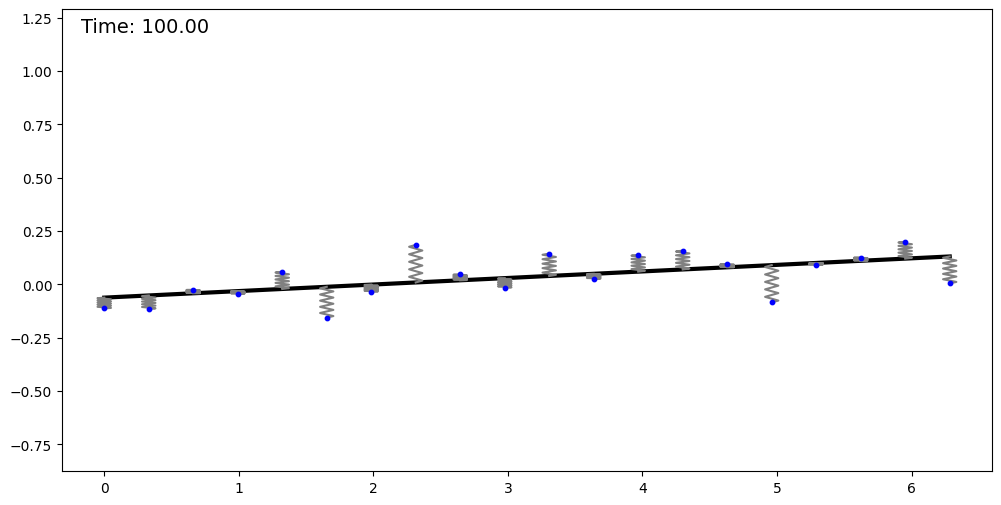

In [386]:
generalized_animation(ts, ys_gen[:,0,:], np.array(u_i.flatten()), np.array(y_i.flatten()), path='anis/speed_ggs3de2.gif')

(array([1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13]),
 [Text(0, 1e-19, '$\\mathdefault{10^{-19}}$'),
  Text(0, 1e-18, '$\\mathdefault{10^{-18}}$'),
  Text(0, 1e-17, '$\\mathdefault{10^{-17}}$'),
  Text(0, 1e-16, '$\\mathdefault{10^{-16}}$'),
  Text(0, 1e-15, '$\\mathdefault{10^{-15}}$'),
  Text(0, 1e-14, '$\\mathdefault{10^{-14}}$'),
  Text(0, 1e-13, '$\\mathdefault{10^{-13}}$')])

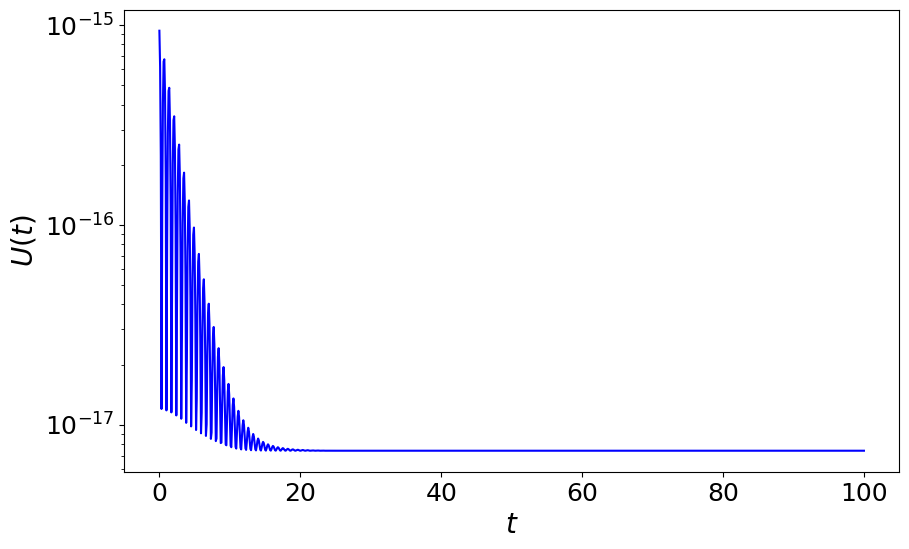

In [397]:
costs = sde.cost(ys_gen[:, 2, :]).detach().numpy()

plt.figure(figsize=(10, 6))
plt.plot(ts, costs, label='Mean Cost', color='blue')
plt.yscale('log')
# plt.fill_between(ts, mean_costs - std_costs, mean_costs + std_costs, color='blue', alpha=0.2)
plt.xlabel(r'$t$', fontsize=20)
plt.ylabel(r'$U(t)$', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

## Entropy production

In [2]:
from src.entropy import get_entropy_rates

In [3]:
def run_simulation(k, M, fric):
    u_i = torch.linspace(0, 2 * torch.pi, 20).reshape(1, -1)
    y_i = 0.1 * torch.randn_like(u_i)
    
    dof = 1
    batch_size, state_size, t_size = 1000, (dof + 1) * 2, 1000
    sde = GGS3DE(dof, u_i, y_i, friction=fric, temp=1, k=k, M=M)
    
    ts = torch.linspace(0, 50, t_size)
    y0 = (torch.rand(size=(batch_size, state_size)) - 0.5) * 3
    
    with torch.no_grad():
        ys_gen = torchsde.sdeint(sde, y0, ts, method='euler')  
    
    all_costs = torch.stack([sde.cost(ys_gen[:, I, :]) for I in range(batch_size)], dim=1).detach().numpy()
    costs_mean = all_costs.mean(axis=1)
    costs_std = all_costs.std(axis=1)
    pit, phit, dSdt = get_entropy_rates(ys_gen, sde)
    
    return ts, pit, phit, dSdt, costs_mean, costs_std, all_costs

In [7]:
k_values = [1e-16, 1e-18, 1e-20, 1e-22]
M_values = [1e-16, 1e-18, 1e-20, 1e-22]
fric = [0.2, 0.5, 1, 2, 5]

results = {}

for k, M in zip(k_values, M_values):
    for fr in fric:
        ts, pit, phit, dSdt, costs_mean, costs_std, all_costs = run_simulation(k, M, fr)
        results[(k, M, fr)] = (ts, pit, phit, dSdt, costs_mean, costs_std, all_costs)

import pickle
with open('data/entropy_results.pkl', 'wb') as f:
    pickle.dump(results, f)

Creating symbols...
Calculating kinetic energy...
Iterating over 2 dimensions
Calculating kinetic energy for dimension 0...
Calculating rotational kinetic energy...
Calculating rotational kinetic energy for dimension 0...
Calculating potential energy...
Calculating potential energy for point 0...
Calculating potential energy for point 1...
Calculating potential energy for point 2...
Calculating potential energy for point 3...
Calculating potential energy for point 4...
Calculating potential energy for point 5...
Calculating potential energy for point 6...
Calculating potential energy for point 7...
Calculating potential energy for point 8...
Calculating potential energy for point 9...
Calculating potential energy for point 10...
Calculating potential energy for point 11...
Calculating potential energy for point 12...
Calculating potential energy for point 13...
Calculating potential energy for point 14...
Calculating potential energy for point 15...
Calculating potential energy for poi

/Users/luismantilla/Desktop/UofT/2024-1/Projects/SpringsSticks/springs-and-sticks/src/entropy.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diag = torch.tensor(diag)


torch.Size([1000]) torch.Size([1000]) torch.Size([1000])
Creating symbols...
Calculating kinetic energy...
Iterating over 2 dimensions
Calculating kinetic energy for dimension 0...
Calculating rotational kinetic energy...
Calculating rotational kinetic energy for dimension 0...
Calculating potential energy...
Calculating potential energy for point 0...
Calculating potential energy for point 1...
Calculating potential energy for point 2...
Calculating potential energy for point 3...
Calculating potential energy for point 4...
Calculating potential energy for point 5...
Calculating potential energy for point 6...
Calculating potential energy for point 7...
Calculating potential energy for point 8...
Calculating potential energy for point 9...
Calculating potential energy for point 10...
Calculating potential energy for point 11...
Calculating potential energy for point 12...
Calculating potential energy for point 13...
Calculating potential energy for point 14...
Calculating potential en

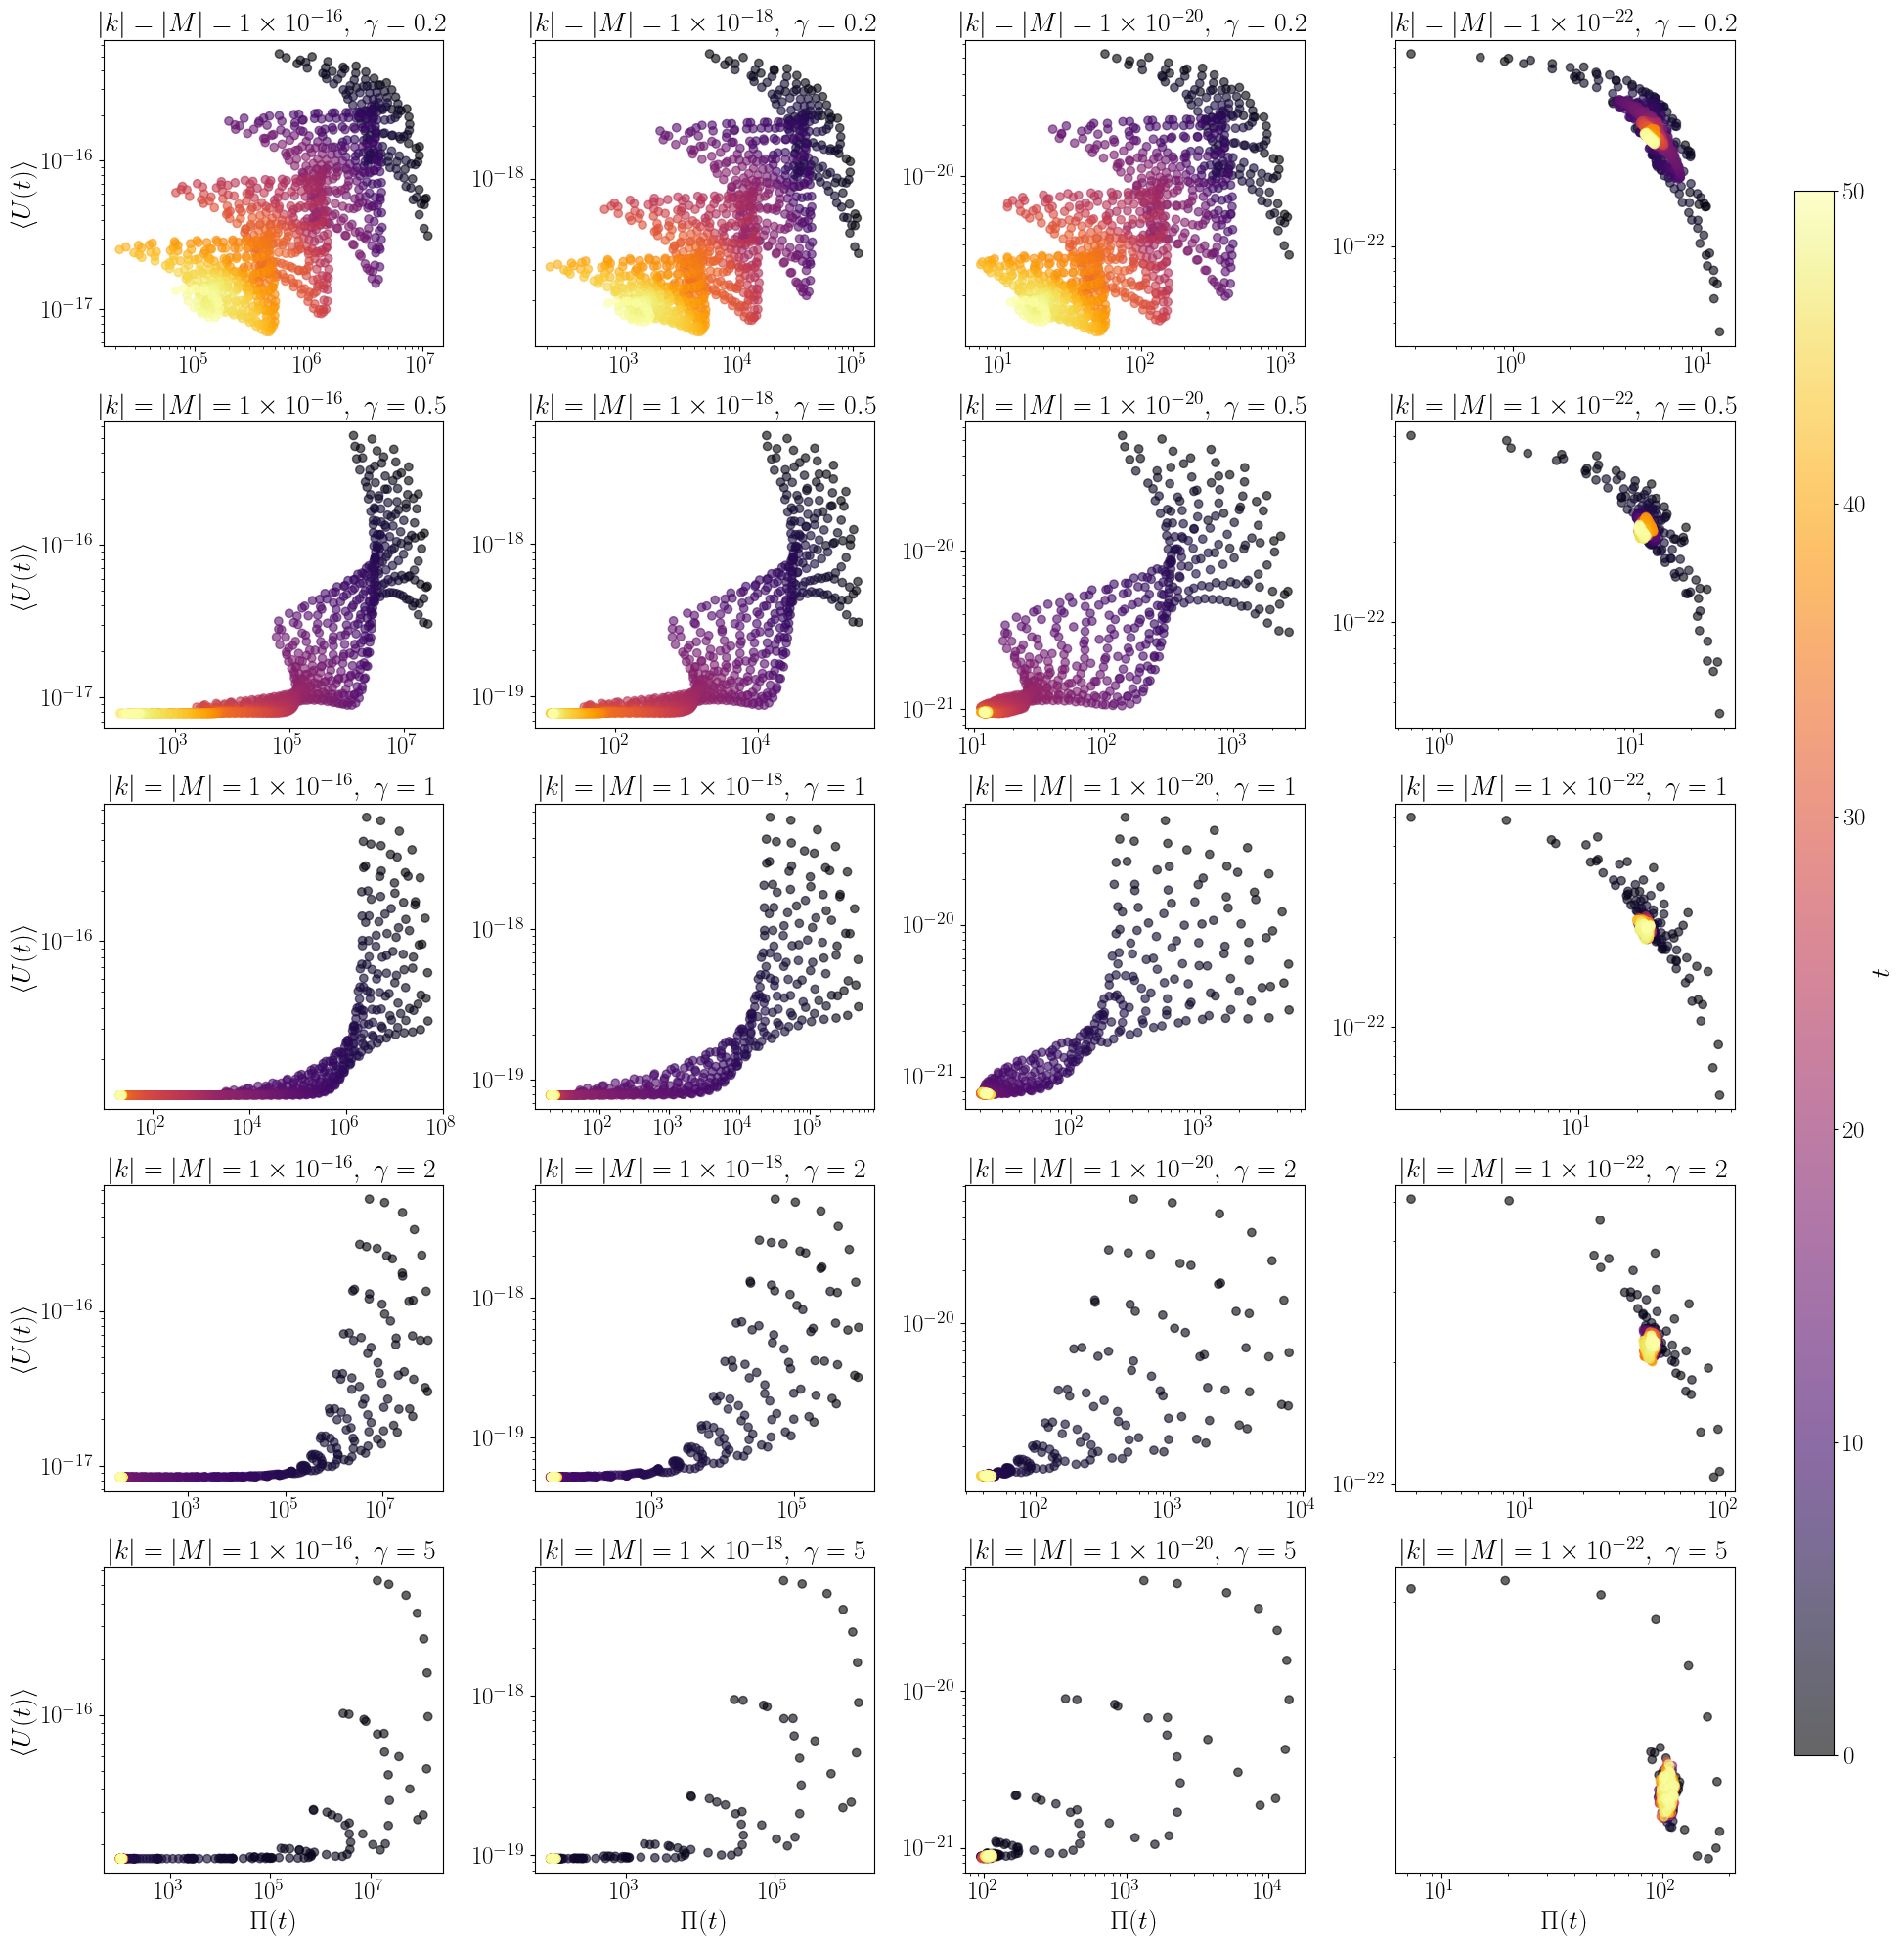

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

# Enable LaTeX rendering for axes
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Load the results dictionary
with open('data/entropy_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Define the number of rows and columns
num_rows = len(fric)
num_cols = len(k_values)

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))#, sharex='col', sharey='row')

# Plot each simulation result
for (k, M, fr), (ts, pit, phit, dSdt, costs_mean, costs_std, all_costs) in results.items():
    row = fric.index(fr)
    col = k_values.index(k)
    ax = axes[row, col]
    
    scatter = ax.scatter(pit, costs_mean, c=ts, cmap='inferno', alpha=0.6)
    ax.set_yscale('log')
    ax.set_xscale('log')
    if row == num_rows - 1:
        ax.set_xlabel(r'$\Pi(t)$', fontsize=20)
    if col == 0:
        ax.set_ylabel(r'$\langle U(t) \rangle$', fontsize=20)

    # Format title with scientific notation and LaTeX
    k_sci = f'{k:.0e}'.replace('e', r'\times10^{') + '}'
    M_sci = f'{M:.0e}'.replace('e', r'\times10^{') + '}'
    ax.set_title(rf'$|k|=|M|={k_sci},\ \gamma={fr}$', fontsize=20)

    # Make the ticks slightly larger
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    
    ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0, numticks=4))
    ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs='auto', numticks=4))
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs='auto', numticks=4))
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# Adjust layout to make space for the colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label(r'$t$', fontsize=20)
cbar.ax.tick_params(labelsize=18)

plt.savefig('figs/entropy_production_results.pdf')
plt.show()

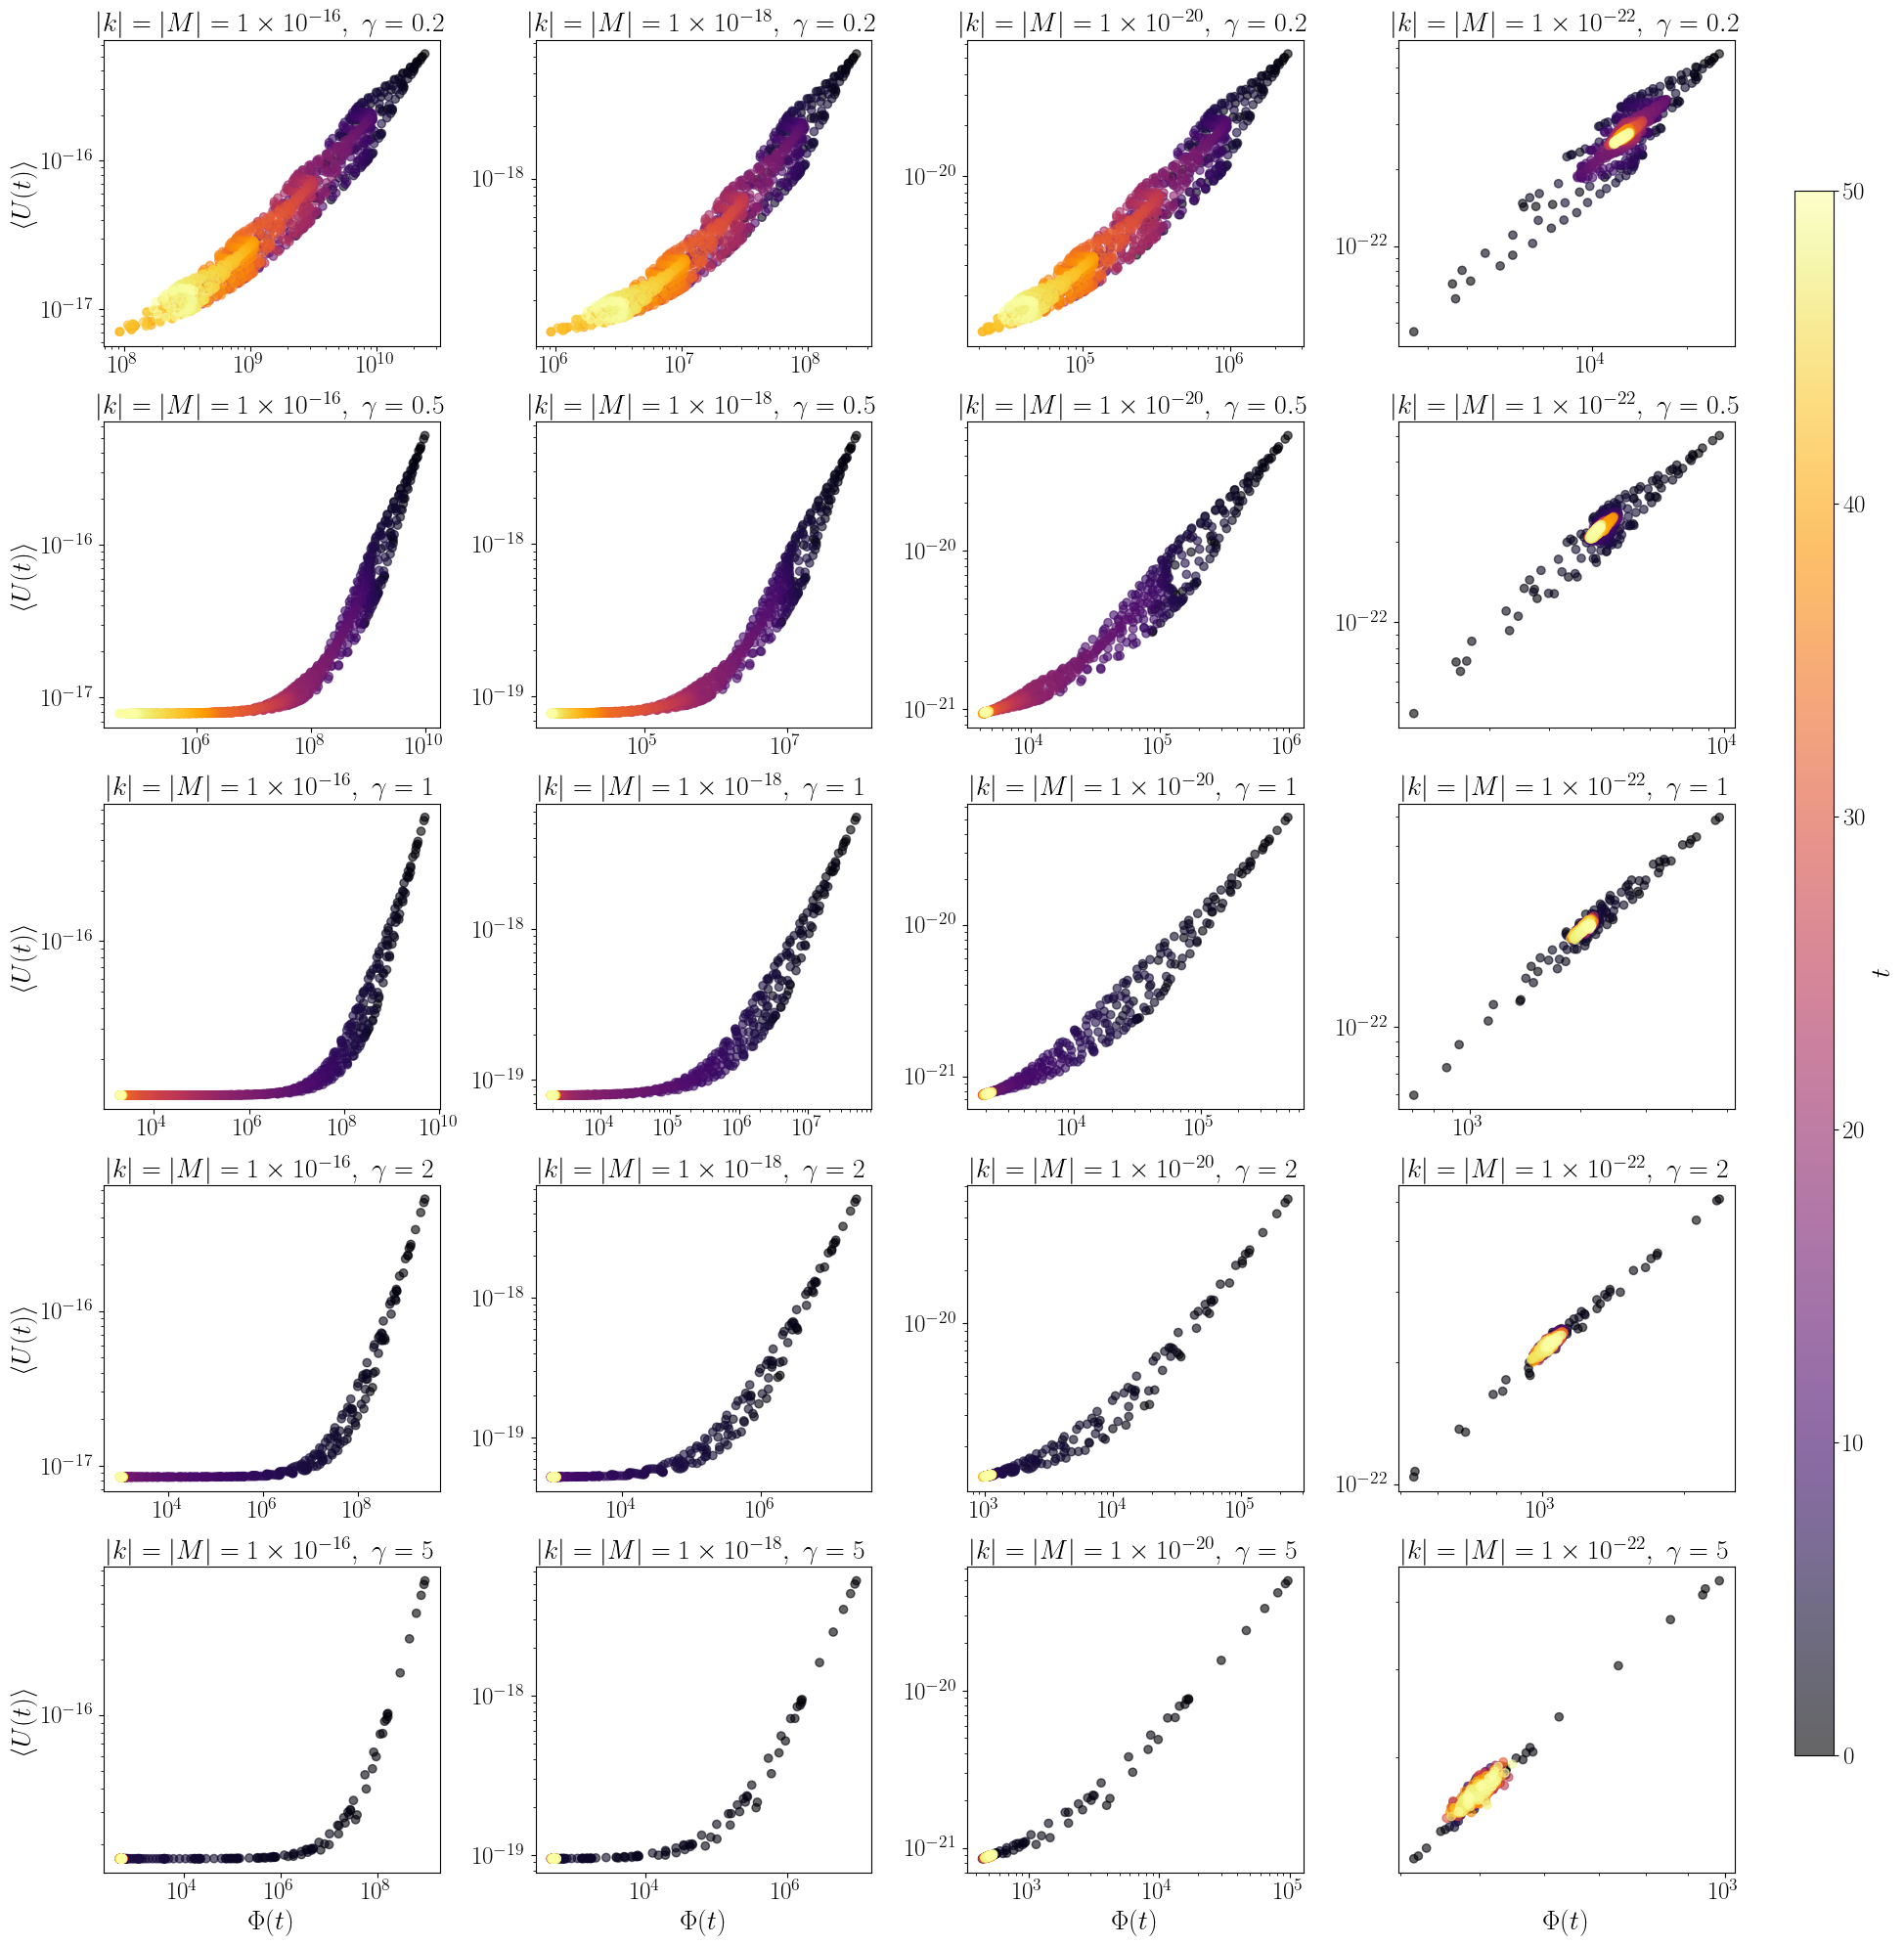

In [12]:
# Define the number of rows and columns
num_rows = len(fric)
num_cols = len(k_values)

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))#, sharex='col', sharey='row')

# Plot each simulation result
for (k, M, fr), (ts, pit, phit, dSdt, costs_mean, costs_std, all_costs) in results.items():
    row = fric.index(fr)
    col = k_values.index(k)
    ax = axes[row, col]
    
    scatter = ax.scatter(phit, costs_mean, c=ts, cmap='inferno', alpha=0.6)
    ax.set_yscale('log')
    ax.set_xscale('log')
    if row == num_rows - 1:
        ax.set_xlabel(r'$\Phi(t)$', fontsize=20)
    if col == 0:
        ax.set_ylabel(r'$\langle U(t) \rangle$', fontsize=20)

    # Format title with scientific notation and LaTeX
    k_sci = f'{k:.0e}'.replace('e', r'\times10^{') + '}'
    M_sci = f'{M:.0e}'.replace('e', r'\times10^{') + '}'
    ax.set_title(rf'$|k|=|M|={k_sci},\ \gamma={fr}$', fontsize=20)

    # Make the ticks slightly larger
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    
    ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0, numticks=4))
    ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs='auto', numticks=4))
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs='auto', numticks=4))
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# Adjust layout to make space for the colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label(r'$t$', fontsize=20)
cbar.ax.tick_params(labelsize=18)

plt.savefig('figs/entropy_flux_results.pdf')
plt.show()

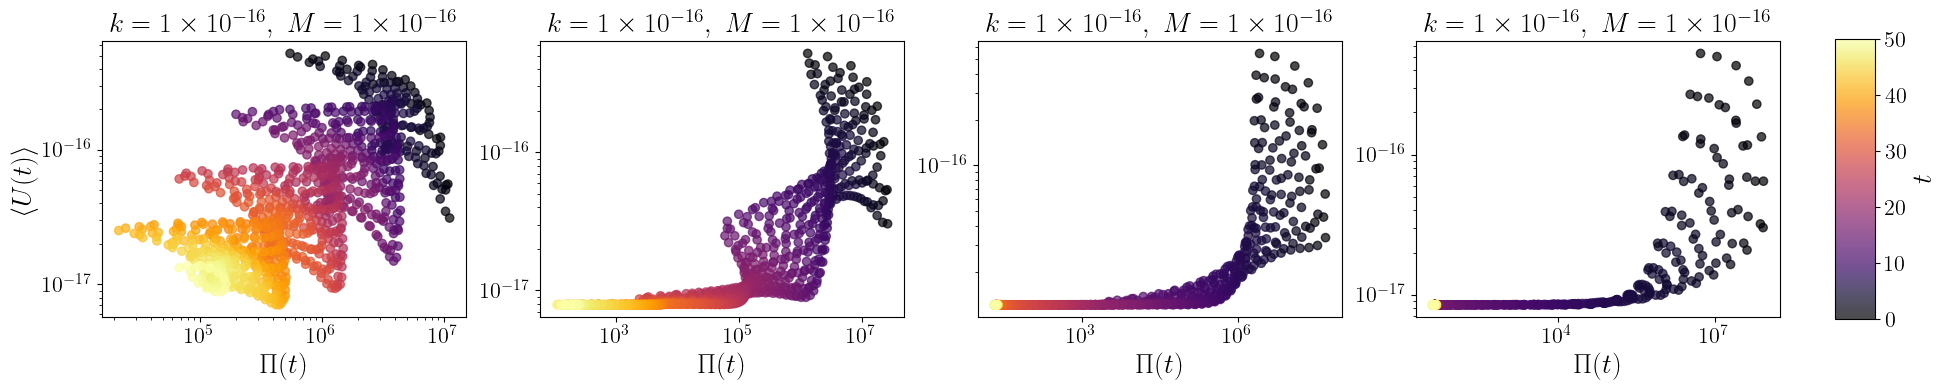

In [45]:
# Load the results dictionary
with open('data/entropy_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Create the subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# Plot each simulation result
for i, ((k, M, fr), (ts, pit, phit, dSdt, costs_mean, costs_std, all_costs)) in enumerate(results.items()):
    if i >= 4:
        break
    scatter = axes[i].scatter(pit, costs_mean, c=ts, cmap='inferno', alpha=0.7)
    axes[i].set_yscale('log')
    axes[i].set_xscale('log')
    axes[i].set_xlabel(r'$\Pi(t)$', fontsize=20)
    if i == 0:
        axes[i].set_ylabel(r'$\langle U(t) \rangle$', fontsize=20)
    else:
        axes[i].set_ylabel('')  # Remove y-label for all but the first plot
    
    # Format title with scientific notation and LaTeX
    k_sci = f'{k:.0e}'.replace('e', r'\times10^{') + '}'
    M_sci = f'{M:.0e}'.replace('e', r'\times10^{') + '}'
    axes[i].set_title(rf'$k={k_sci},\ M={M_sci}$', fontsize=20)

    # Make the ticks slightly larger
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    axes[i].tick_params(axis='both', which='minor', labelsize=16)
    
    axes[i].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0, numticks=3))
    axes[i].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs='auto', numticks=3))
    axes[i].xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    axes[i].yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0, numticks=3))
    axes[i].yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs='auto', numticks=3))
    axes[i].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())


# Adjust layout to make space for the colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.19, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label(r'$t$', fontsize=20)
cbar.ax.tick_params(labelsize=16)

plt.savefig('figs/entropy_results.pdf')
plt.show()

How much energy do we need?

How does Q look vs signal to noise ratio?

In [95]:
import matplotlib.pyplot as plt
from scipy import integrate
import numpy as np

# range of 1e-10 to 1e-24 every order of magnitude
k_values = np.logspace(-10, -24, 15)
M_values = np.logspace(-10, -24, 15)

fric = [0.2, 0.5, 1, 2, 5]

many_results = {}

for k, M in zip(k_values, M_values):
    for fr in fric:
        ts, pit, phit, dSdt, costs_mean, costs_std, all_costs = run_simulation(k, M, fr)
        many_results[(k, M, fr)] = (ts, pit, phit, dSdt, costs_mean, costs_std, all_costs)

import pickle
with open('data/many_entropy_results.pkl', 'wb') as f:
    pickle.dump(many_results, f)

Creating symbols...
Calculating kinetic energy...
Iterating over 2 dimensions
Calculating kinetic energy for dimension 0...
Calculating rotational kinetic energy...
Calculating rotational kinetic energy for dimension 0...
Calculating potential energy...
Calculating potential energy for point 0...
Calculating potential energy for point 1...
Calculating potential energy for point 2...
Calculating potential energy for point 3...
Calculating potential energy for point 4...
Calculating potential energy for point 5...
Calculating potential energy for point 6...
Calculating potential energy for point 7...
Calculating potential energy for point 8...
Calculating potential energy for point 9...
Calculating potential energy for point 10...
Calculating potential energy for point 11...
Calculating potential energy for point 12...
Calculating potential energy for point 13...
Calculating potential energy for point 14...
Calculating potential energy for point 15...
Calculating potential energy for poi

/Users/luismantilla/Desktop/UofT/2024-1/Projects/SpringsSticks/springs-and-sticks/src/entropy.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diag = torch.tensor(diag)


torch.Size([1000]) torch.Size([1000]) torch.Size([1000])
Creating symbols...
Calculating kinetic energy...
Iterating over 2 dimensions
Calculating kinetic energy for dimension 0...
Calculating rotational kinetic energy...
Calculating rotational kinetic energy for dimension 0...
Calculating potential energy...
Calculating potential energy for point 0...
Calculating potential energy for point 1...
Calculating potential energy for point 2...
Calculating potential energy for point 3...
Calculating potential energy for point 4...
Calculating potential energy for point 5...
Calculating potential energy for point 6...
Calculating potential energy for point 7...
Calculating potential energy for point 8...
Calculating potential energy for point 9...
Calculating potential energy for point 10...
Calculating potential energy for point 11...
Calculating potential energy for point 12...
Calculating potential energy for point 13...
Calculating potential energy for point 14...
Calculating potential en

In [118]:
heat_values = {fr: [] for fr in fric}
heat_values_diff = {fr: [] for fr in fric}
snr_values = {fr: [] for fr in fric}
k_m_values = []

for (k, M, fr), (ts, pit, phit, dSdt, costs_mean, costs_std, all_costs) in many_results.items():
    kb = 1.380649e-23
    dq = phit * kb 
    Q = integrate.simpson(dq, ts)
    SNR = costs_mean / costs_std
    # get last 10% of the data
    SNR = SNR[-int(0.3 * len(SNR)):]
    avg_SNR = np.mean(SNR)
    max_energy = np.mean(np.max(all_costs, axis=1))
    min_energy = np.mean(np.min(all_costs, axis=1))
    heat_values_diff[fr].append((k, M, max_energy - min_energy))
    heat_values[fr].append((k, M, Q))
    snr_values[fr].append((k, M, avg_SNR))
    if (k, M) not in k_m_values:
        k_m_values.append((k, M))

/var/folders/x9/8zgqvcbx66q2mjvw0wjdx_fw0000gn/T/ipykernel_45827/3828157359.py:9: DeprecationWarning: You are passing x=tensor([ 0.0000,  0.0501,  0.1001,  0.1502,  0.2002,  0.2503,  0.3003,  0.3504,
         0.4004,  0.4505,  0.5005,  0.5506,  0.6006,  0.6507,  0.7007,  0.7508,
         0.8008,  0.8509,  0.9009,  0.9510,  1.0010,  1.0511,  1.1011,  1.1512,
         1.2012,  1.2513,  1.3013,  1.3514,  1.4014,  1.4515,  1.5015,  1.5516,
         1.6016,  1.6517,  1.7017,  1.7518,  1.8018,  1.8519,  1.9019,  1.9520,
         2.0020,  2.0521,  2.1021,  2.1522,  2.2022,  2.2523,  2.3023,  2.3524,
         2.4024,  2.4525,  2.5025,  2.5526,  2.6026,  2.6527,  2.7027,  2.7528,
         2.8028,  2.8529,  2.9029,  2.9530,  3.0030,  3.0531,  3.1031,  3.1532,
         3.2032,  3.2533,  3.3033,  3.3534,  3.4034,  3.4535,  3.5035,  3.5536,
         3.6036,  3.6537,  3.7037,  3.7538,  3.8038,  3.8539,  3.9039,  3.9540,
         4.0040,  4.0541,  4.1041,  4.1542,  4.2042,  4.2543,  4.3043,  4.3544,


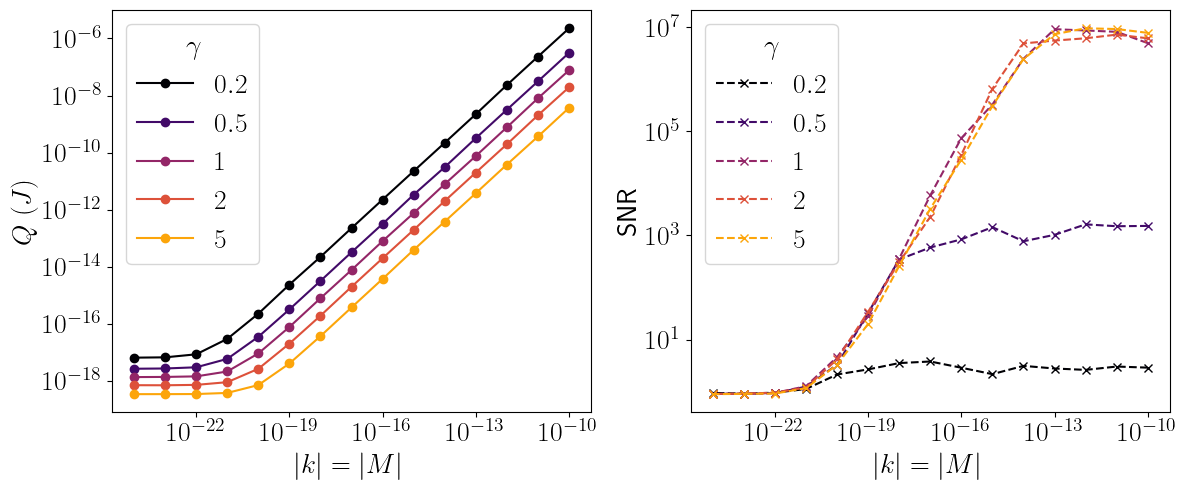

In [120]:
import matplotlib.pyplot as plt
from matplotlib.cm import inferno
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker

# Normalize the friction values
cmap = plt.get_cmap('inferno')

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plotting heat as a function of k and M for different frictions
for indx, fr in enumerate(fric):
    color = cmap(indx / len(fric))
    heat_curve = [Q for (k, M), Q in zip(k_m_values, [Q for _, _, Q in heat_values[fr]])]
    snr_curve = [avg_SNR for (k, M), avg_SNR in zip(k_m_values, [avg_SNR for _, _, avg_SNR in snr_values[fr]])]
    k_m = [k for k, M in k_m_values]
    ax1.plot(k_m, heat_curve, label=rf'${fr}$', linestyle='-', marker='o', color=color)
    ax2.plot(k_m, snr_curve, label=rf'${fr}$', linestyle='--', marker='x', color=color)

# Formatting for the heat plot
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'$|k|=|M|$', fontsize=20)
ax1.set_ylabel(r'$Q \ (J)$', fontsize=20)
# ax1.set_title('Heat (Q) as a function of $k$ and $M$', fontsize=20)

# Formatting for the SNR plot
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel(r'$|k|=|M|$', fontsize=20)
ax2.set_ylabel('SNR', fontsize=20)
# ax2.set_title('SNR as a function of $k$ and $M$', fontsize=20)

# Combine legends from both subplots
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Add legends to the subplots
heat_legend = ax1.legend(lines_1, labels_1, fontsize=20, title=r'$\gamma$', loc='upper left')
snr_legend = ax2.legend(lines_2, labels_2, fontsize=20, title=r'$\gamma$', loc='upper left')

# Set legend titles font size
plt.setp(heat_legend.get_title(), fontsize=20)
plt.setp(snr_legend.get_title(), fontsize=20)

# Set tick parameters for both subplots
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='minor', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=20)

# Set major locator for x-axis
ax1.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=6))
ax2.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=6))

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('figs/heat_snr.pdf')
plt.show()

/var/folders/x9/8zgqvcbx66q2mjvw0wjdx_fw0000gn/T/ipykernel_45827/802347016.py:18: DeprecationWarning: You are passing x=tensor([ 0.0000,  0.0501,  0.1001,  0.1502,  0.2002,  0.2503,  0.3003,  0.3504,
         0.4004,  0.4505,  0.5005,  0.5506,  0.6006,  0.6507,  0.7007,  0.7508,
         0.8008,  0.8509,  0.9009,  0.9510,  1.0010,  1.0511,  1.1011,  1.1512,
         1.2012,  1.2513,  1.3013,  1.3514,  1.4014,  1.4515,  1.5015,  1.5516,
         1.6016,  1.6517,  1.7017,  1.7518,  1.8018,  1.8519,  1.9019,  1.9520,
         2.0020,  2.0521,  2.1021,  2.1522,  2.2022,  2.2523,  2.3023,  2.3524,
         2.4024,  2.4525,  2.5025,  2.5526,  2.6026,  2.6527,  2.7027,  2.7528,
         2.8028,  2.8529,  2.9029,  2.9530,  3.0030,  3.0531,  3.1031,  3.1532,
         3.2032,  3.2533,  3.3033,  3.3534,  3.4034,  3.4535,  3.5035,  3.5536,
         3.6036,  3.6537,  3.7037,  3.7538,  3.8038,  3.8539,  3.9039,  3.9540,
         4.0040,  4.0541,  4.1041,  4.1542,  4.2042,  4.2543,  4.3043,  4.3544,


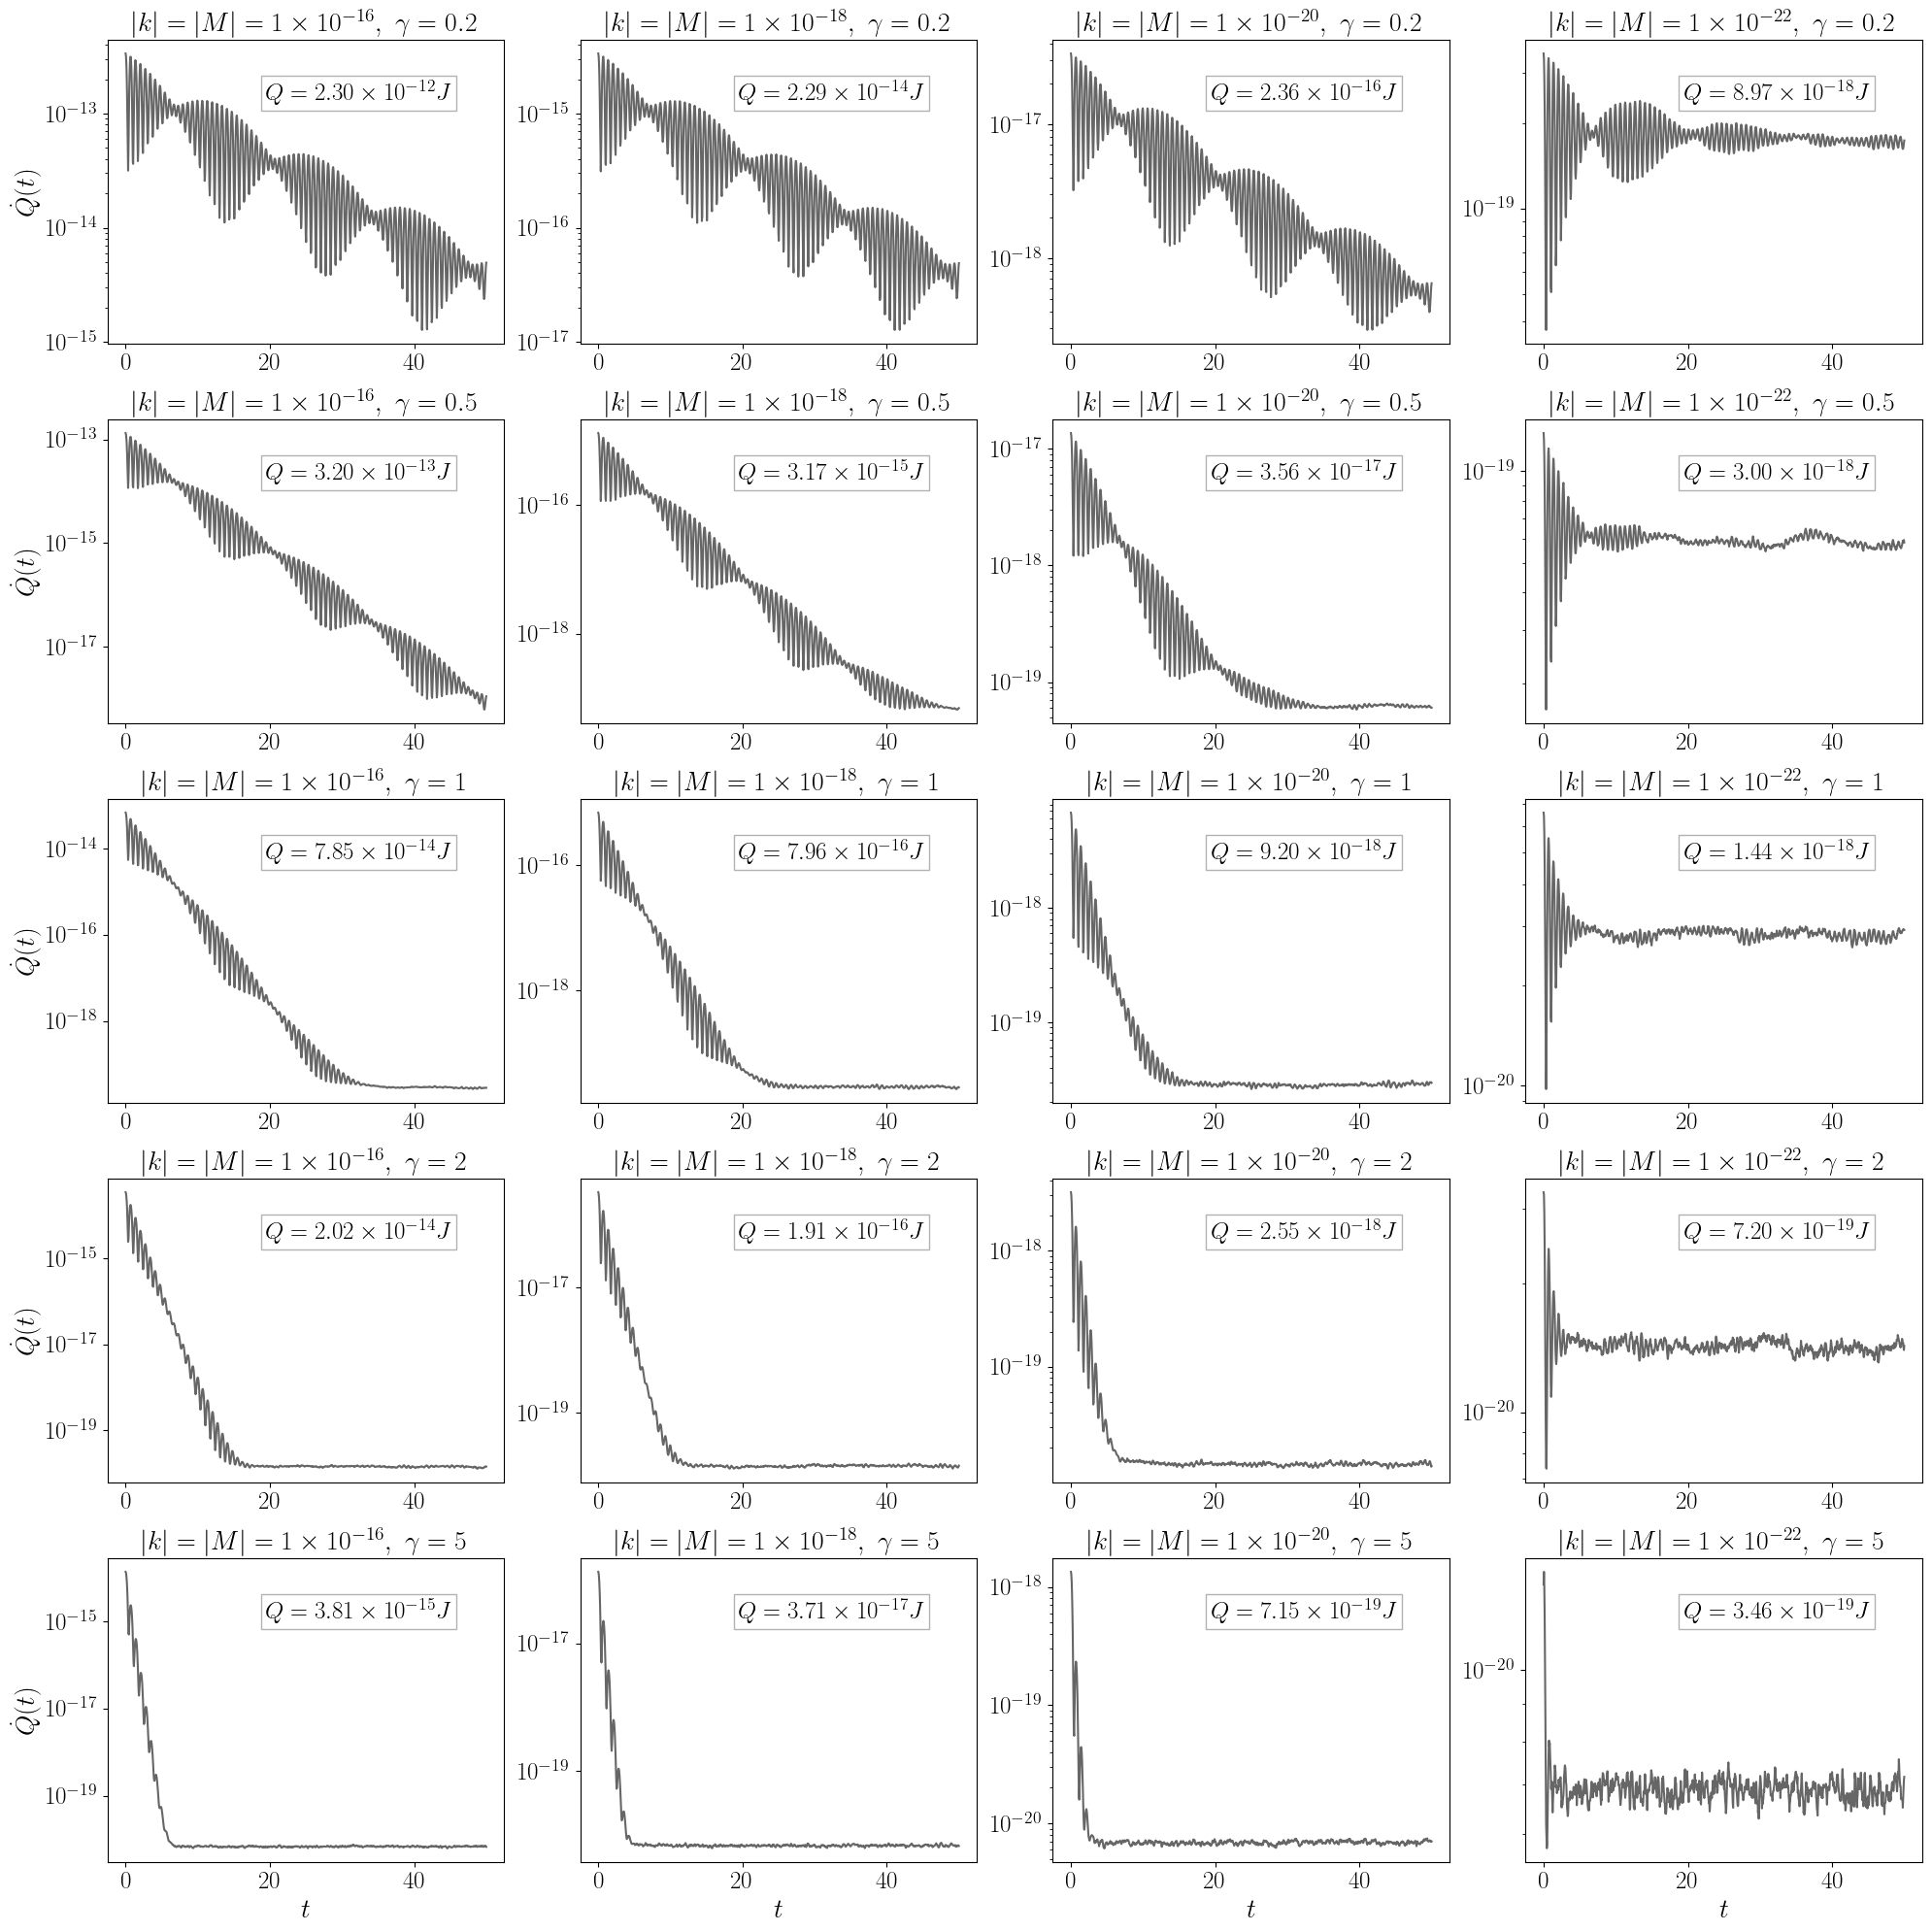

In [44]:
from scipy import integrate

# Define the number of rows and columns
num_rows = len(fric)
num_cols = len(k_values)

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))#, sharex='col', sharey='row')

# Plot each simulation result
for (k, M, fr), (ts, pit, phit, dSdt, costs_mean, costs_std, all_costs) in results.items():
    row = fric.index(fr)
    col = k_values.index(k)
    ax = axes[row, col]
    
    kb = 1.380649e-23
    dq = phit * kb
    Q = integrate.simpson(dq, ts)
    scatter = ax.plot(ts, dq, c='black', alpha=0.6)
    ax.set_yscale('log')
    q_text = rf'$Q = {Q:.2e}'
    q_text = q_text.replace('e', r'\times10^{') + '} J$'
    ax.text(0.4, 0.8, q_text,transform=ax.transAxes, fontsize=18, bbox=dict(facecolor='white', alpha=0.3))

    if row == num_rows - 1:
        ax.set_xlabel(r'$t$', fontsize=20)
    if col == 0:
        ax.set_ylabel(r'$\dot{Q}(t)$', fontsize=20)

    # Format title with scientific notation and LaTeX
    k_sci = f'{k:.0e}'.replace('e', r'\times10^{') + '}'
    M_sci = f'{M:.0e}'.replace('e', r'\times10^{') + '}'
    ax.set_title(rf'$|k|=|M|={k_sci},\ \gamma={fr}$', fontsize=20)

    # Make the ticks slightly larger
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs='auto', numticks=4))
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# Adjust layout to make space for the colorbar
# plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.tight_layout()

plt.savefig('figs/heat_results.pdf')
plt.show()

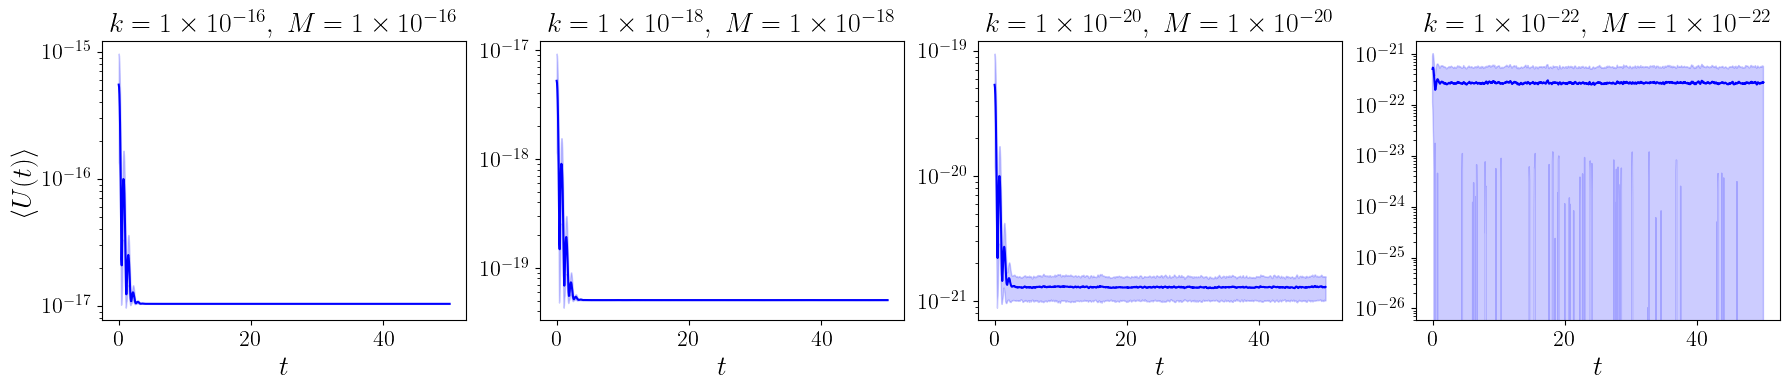

In [506]:
# Create the subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# Plot each simulation result
for i, ((k, M), (ts, pit, costs_mean, costs_std, all_costs)) in enumerate(results.items()):
    plot = axes[i].plot(ts, costs_mean, color='blue')
    axes[i].fill_between(ts, costs_mean - costs_std, costs_mean + costs_std, color='blue', alpha=0.2)
    axes[i].set_yscale('log')
    # axes[i].set_xscale('log')
    axes[i].set_xlabel(r'$t$', fontsize=20)
    if i == 0:
        axes[i].set_ylabel(r'$\langle U(t) \rangle$', fontsize=20)
    else:
        axes[i].set_ylabel('')  # Remove y-label for all but the first plot
    
    # Format title with scientific notation and LaTeX
    k_sci = f'{k:.0e}'.replace('e', r'\times10^{') + '}'
    M_sci = f'{M:.0e}'.replace('e', r'\times10^{') + '}'
    axes[i].set_title(rf'$k={k_sci},\ M={M_sci}$', fontsize=20)

    # Make the ticks slightly larger
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    axes[i].tick_params(axis='both', which='minor', labelsize=16)

plt.tight_layout(rect=[0, 0, 0.9, 1])

plt.savefig('figs/scale_results.pdf')
plt.show()

# 2D

In [7]:
np.random.seed(100)

n_pieces = torch.tensor([1,1])
u_i = torch.tensor([[1,2,3,4,5,6], [1,2,3,4,5,6]])

y_i = torch.rand(2,6)

batch_size, state_size, t_size = 2, torch.prod(n_pieces + torch.ones_like(n_pieces))*2*y_i.shape[0], 200
sde = GGS3DE(n_pieces, u_i, y_i, friction=2, temp=1, k=1, M=1)
ts = torch.linspace(0, 20, t_size)

y0 = torch.rand(size=(batch_size, state_size))

with torch.no_grad():
    ys_gen = torchsde.sdeint(sde, y0, ts, method='euler')  # (t_size, batch_size, state_size)

Creating symbols...
Calculating kinetic energy...
Iterating over 3 dimensions
Calculating kinetic energy for dimension 0...
Calculating kinetic energy for dimension 1...
Calculating rotational kinetic energy...
Calculating rotational kinetic energy for dimension 0...
Calculating rotational kinetic energy for dimension 1...
Calculating potential energy...
Calculating potential energy for point 0...
Calculating potential energy for point 1...
Calculating potential energy for point 2...
Calculating potential energy for point 3...
Calculating potential energy for point 4...
Calculating potential energy for point 5...
Calculating Lagrangian...
Done initializing.


In [115]:
ys_gen[:,0,:].shape, u_i.shape, y_i.shape, n_pieces

(torch.Size([200, 8]), torch.Size([2, 6]), torch.Size([1, 6]), tensor([1, 1]))

'anis/speed_3d_11.gif'

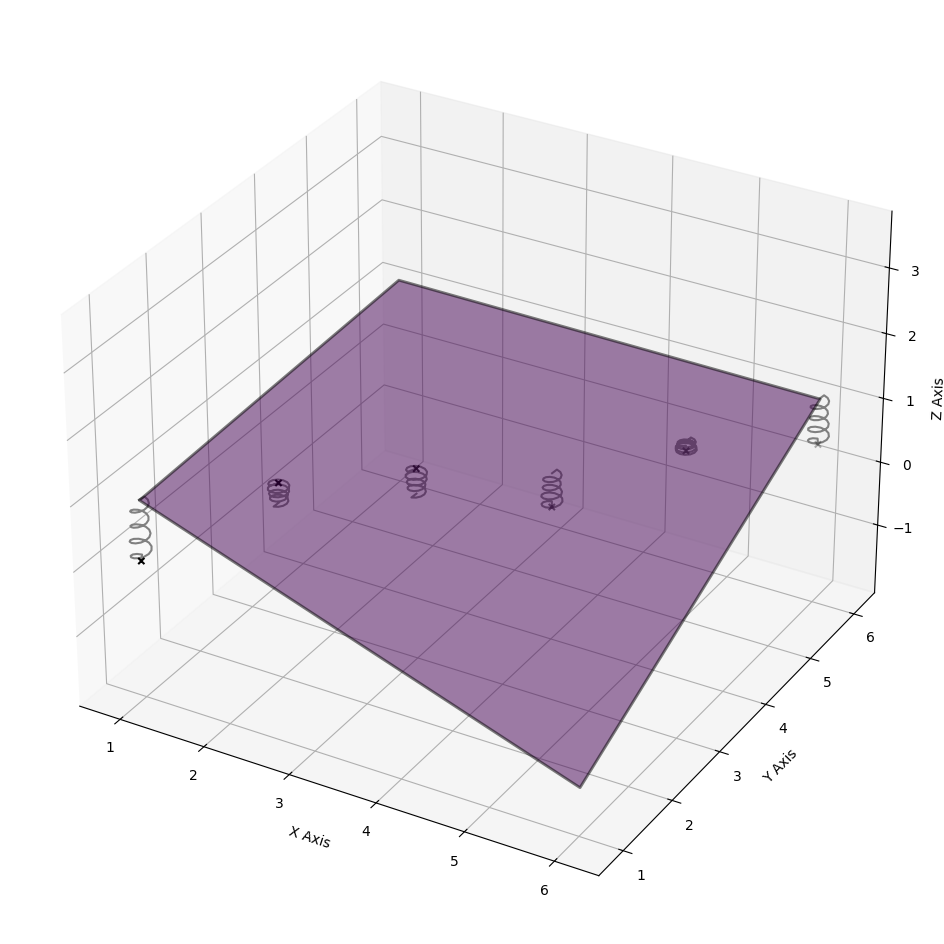

In [118]:
from springs_plot import generalized_animation_3d

generalized_animation_3d(ts, ys_gen[:,0,:], u_i, y_i, np.array(n_pieces + torch.ones_like(n_pieces)), sde, path="anis/speed_3d_11.gif")

# Mnist

In [1]:
import torch
import torchsde
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Number of data points
ndata_train = 20
ndata_test = 20

# Transformations for the dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))]
)

# Load training and test datasets
trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=len(trainset), shuffle=True
)

testset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=len(testset), shuffle=True
)

# Get full training data
u_i_train, y_train = next(iter(trainloader))
u_i_test, y_test = next(iter(testloader))

# One-hot encoding of the labels
y_i_train = torch.nn.functional.one_hot(y_train, num_classes=10)
y_i_test = torch.nn.functional.one_hot(y_test, num_classes=10)

print("Preprocessing data...")

# Center and normalize the training data
u_i_train_centered = u_i_train - u_i_train.mean(axis=0)
u_i_train_normalized = u_i_train_centered / (u_i_train_centered.std(axis=0) + 1e-10)

# Apply the same transformation to the test data
u_i_test_centered = u_i_test - u_i_train.mean(axis=0)
u_i_test_normalized = u_i_test_centered / (u_i_train.std(axis=0) + 1e-10)

# Get 4 PCA components of u_i_train
pca = PCA(n_components=4)
u_i_train_pca = torch.tensor(pca.fit_transform(u_i_train_normalized))
u_i_test_pca = torch.tensor(pca.transform(u_i_test_normalized))

# Split the train data into smaller sets
u_i_train_pca_small = u_i_train_pca[:ndata_train, :]
y_i_train_small = y_i_train[:ndata_train, :]

# Split the test data into smaller sets
u_i_test_pca_small = u_i_test_pca[:ndata_test, :]
y_i_test_small = y_i_test[:ndata_test, :]

print("Training data size:", u_i_train_pca_small.shape)
print("Test data size:", u_i_test_pca_small.shape)

/Users/luismantilla/miniforge3/envs/huggingface/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/luismantilla/miniforge3/envs/huggingface/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <6DFB383A-E1D9-3EC6-8A60-382AF4E3C226> /Users/luismantilla/miniforge3/envs/huggingface/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <3FE16EFD-B5EE-33D2-A4C8-2BD93F2AA7BA> /Users/luismantilla/miniforge3/envs/huggingface/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Preprocessing data...
Training data size: torch.Size([20, 4])
Test data size: torch.Size([20, 4])


In [4]:
n_pieces_train = torch.ones_like(u_i_train_pca_small[0], dtype=int)
n_pieces_test = torch.ones_like(u_i_test_pca_small[0], dtype=int)

batch_size = 1

state_size_train = torch.prod(n_pieces_train + 1) * 2 * y_i_train_small.shape[0]
t_size_train = 50

state_size_test = torch.prod(n_pieces_test + 1) * 2 * y_i_test_small.shape[0]
t_size_test = 50

sde_train = GGS3DE(
    n_pieces_train, u_i_train_pca_small.T, y_i_train_small.T, friction=100, temp=1, k=1, M=1
)
sde_test = GGS3DE(
    n_pieces_test, u_i_test_pca_small.T, y_i_test_small.T, friction=100, temp=1, k=1, M=1
)

Creating symbols...
Calculating kinetic energy...
Iterating over 5 dimensions
Calculating kinetic energy for dimension 0...
Calculating kinetic energy for dimension 1...
Calculating kinetic energy for dimension 2...
Calculating kinetic energy for dimension 3...
Calculating rotational kinetic energy...
Calculating rotational kinetic energy for dimension 0...
Calculating rotational kinetic energy for dimension 1...
Calculating rotational kinetic energy for dimension 2...
Calculating rotational kinetic energy for dimension 3...
Calculating potential energy...
Calculating potential energy for point 0...
Calculating potential energy for point 1...
Calculating potential energy for point 2...
Calculating potential energy for point 3...
Calculating potential energy for point 4...
Calculating potential energy for point 5...
Calculating potential energy for point 6...
Calculating potential energy for point 7...
Calculating potential energy for point 8...
Calculating potential energy for point 9.

In [7]:
t_size = 50
ts = torch.linspace(0, 20, t_size)
y0 = torch.rand(size=(batch_size, state_size_train))

with torch.no_grad():
    ys_gen = torchsde.sdeint(sde_train, y0, ts, method="euler")

In [11]:
train_cost = sde_train.cost(ys_gen[:, 0, :]).detach().numpy()/ndata_train
test_cost = sde_test.cost(ys_gen[:, 0, :]).detach().numpy()/ndata_test

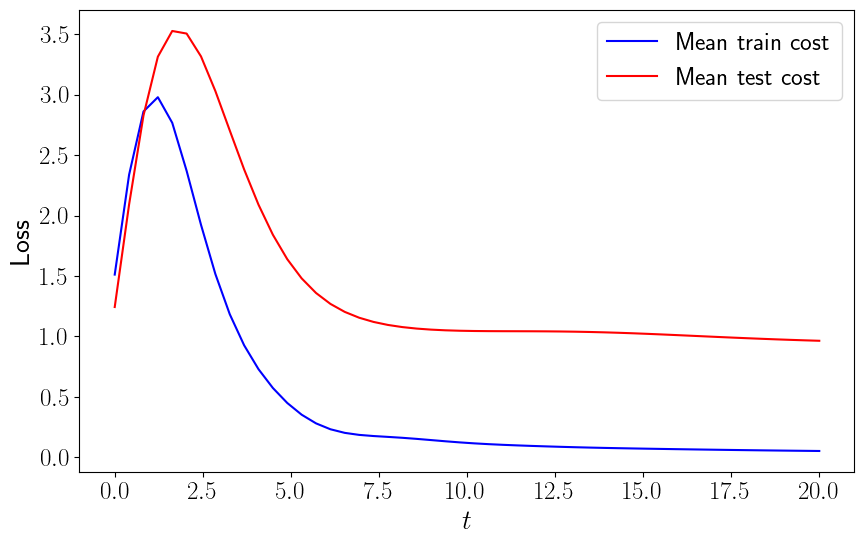

In [19]:
# set latex rendering
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.figure(figsize=(10, 6))
plt.plot(ts, train_cost, label='Mean train cost', color='blue')
plt.plot(ts, test_cost, label='Mean test cost', color='red')

plt.xlabel(r'$t$', fontsize=20)
plt.ylabel(r'Loss', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.savefig('figs/mnist_potential_energy.pdf', bbox_inches='tight')

In [12]:
costs = sde.cost(ys_gen[:, 0, :]).detach().numpy()

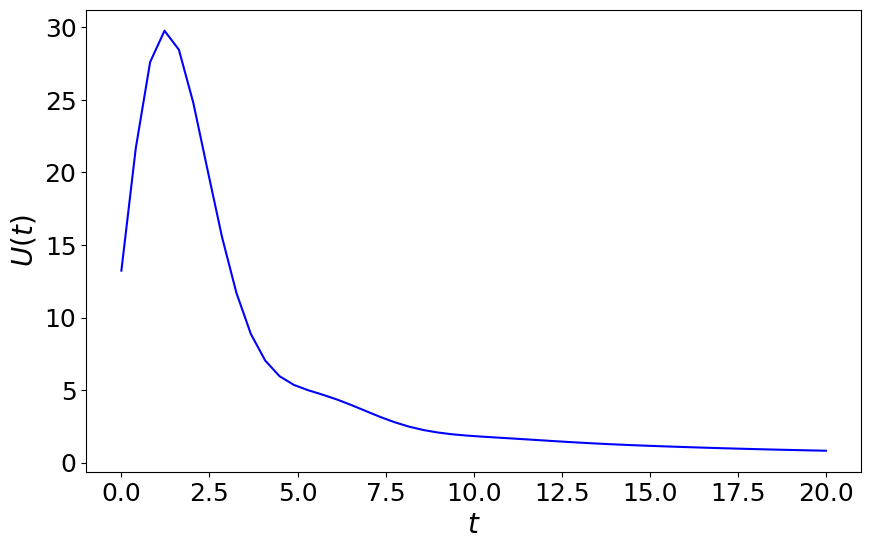

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(ts, costs, label='Mean Cost', color='blue')
# plt.fill_between(ts, mean_costs - std_costs, mean_costs + std_costs, color='blue', alpha=0.2)
plt.xlabel(r'$t$', fontsize=20)
plt.ylabel(r'$U(t)$', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('figs/mnist_potential_energy.pdf', bbox_inches='tight')